<a href="https://colab.research.google.com/github/wl2748/5242_project/blob/main/CNN_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from keras import backend as K

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [3]:
class DataProcessing:
    def __init__(self, file, train):
        self.file = file                                # 读取数据
        self.train = train                              # 训练集所占比例     
        self.i = int(self.train * len(self.file))       # 训练集大小（具体数字）
        self.stock_train = self.file[0: self.i]         # 得到训练集
        self.stock_test = self.file[self.i:]            # 得到测试集
        self.input_train = []
        self.output_train = []
        self.input_test = []
        self.output_test = []

    def gen_train(self, seq_len):
        """
        Generates training data
        :param seq_len: length of window
        :return: X_train and Y_train
        """
        for i in range((len(self.stock_train)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_train.iloc[i: i+seq_len])
            y = np.array([self.stock_train.iloc[i+seq_len]], np.float64)
            self.input_train.append(x)
            self.output_train.append(y)
        self.X_train = np.array(self.input_train)
        self.Y_train = np.array(self.output_train)

    def gen_test(self, seq_len):
        """
        Generates test data
        :param seq_len: Length of window
        :return: X_test and Y_test
        """
        for i in range((len(self.stock_test)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_test.iloc[i: i+seq_len], np.float64)
            y = np.array([self.stock_test.iloc[i+seq_len]], np.float64)
            self.input_test.append(x)
            self.output_test.append(y)
        self.X_test = np.array(self.input_test)
        self.Y_test = np.array(self.output_test)

In [4]:
national_debt = pd.read_excel('中债国债收益率曲线.xls', parse_dates=True)
national_debt = national_debt.iloc[1:4664,1:]
national_debt_s = national_debt.iloc[:,:national_debt.shape[1]-2].dropna()
national_debt_l = national_debt.iloc[:,national_debt.shape[1]-2:].dropna()

In [6]:
data = pd.DataFrame(national_debt_s.iloc[:,15])
data.head()

,中债国债到期收益率:10年
1060,2.9291
1069,3
1070,3.048
1071,3.05
1076,3


In [7]:

### standardize the data:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = pd.DataFrame(scaler.fit_transform(data))

In [164]:
p = 0.8
n = 50
e = 100
process_data = DataProcessing(data_scaled, p)
process_data.gen_test(n)
process_data.gen_train(n)
    
# reshape训练集和测试集，用来建立模型ß
r_train = int((len(data)*p//n)*n - n - 1)
r_test = int((len(data)*(1-p)//n)*n - n - 1)
x_train = process_data.X_train.reshape((r_train,n,1))
y_train = process_data.Y_train.reshape((r_train,1,1))
x_test = process_data.X_test.reshape((r_test,n,1))
y_test = process_data.Y_test.reshape((r_test,1,1))

# 将数据转化成可用于 Tensorflow 使用的 float 形式：
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_test = K.cast_to_floatx(x_test)
y_test = K.cast_to_floatx(y_test)

In [165]:

### 建立一个callback的class：
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.0001):
      print('\nLoss is low so cancelling training!')
      self.model.stop_training = True
callbacks = myCallback()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [205]:
model_cnn = tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides = 1, padding = 'same' ,activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides = 1, padding = 'same',activation='relu'),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(50, activation='relu'),
                tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [206]:
model_cnn.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 50, 32)            128       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 25, 64)            6208      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 50)                38450     
_________________________________________________________________
dense_41 (Dense)             (None, 1)               

In [207]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss="mean_squared_error")

In [208]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [209]:
history = model_cnn.fit(train.shuffle(10000).repeat(10).batch(32).prefetch(1), epochs=e, verbose=2,validation_data=(x_test, y_test) ,callbacks=[early_stopping_cb])


Epoch 1/100
860/860 - 2s - loss: 0.0027 - val_loss: 6.7931e-04
Epoch 2/100
860/860 - 2s - loss: 3.5556e-04 - val_loss: 4.7927e-04
Epoch 3/100
860/860 - 2s - loss: 2.6685e-04 - val_loss: 4.1353e-04
Epoch 4/100
860/860 - 2s - loss: 2.3772e-04 - val_loss: 4.1706e-04
Epoch 5/100
860/860 - 2s - loss: 2.2225e-04 - val_loss: 3.4570e-04
Epoch 6/100
860/860 - 2s - loss: 2.1368e-04 - val_loss: 4.2799e-04
Epoch 7/100
860/860 - 2s - loss: 2.0342e-04 - val_loss: 3.2099e-04
Epoch 8/100
860/860 - 2s - loss: 1.9864e-04 - val_loss: 3.4638e-04
Epoch 9/100
860/860 - 2s - loss: 1.9280e-04 - val_loss: 3.6234e-04
Epoch 10/100
860/860 - 2s - loss: 1.9531e-04 - val_loss: 3.9067e-04
Epoch 11/100
860/860 - 2s - loss: 1.8328e-04 - val_loss: 4.0902e-04
Epoch 12/100
860/860 - 2s - loss: 1.7968e-04 - val_loss: 3.6938e-04


In [210]:
test_predict = pd.DataFrame(model_cnn.predict(x_test))
data_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(test_predict.iloc[:,0])))

In [211]:
from scipy import stats
test_y = scaler.inverse_transform(pd.DataFrame(((y_test)).reshape(r_test,1).tolist()))
test_y = pd.DataFrame(test_y)
stats.ttest_ind(data_predict, test_y)

Ttest_indResult(statistic=array([0.19291345]), pvalue=array([0.84705698]))

No handles with labels found to put in legend.


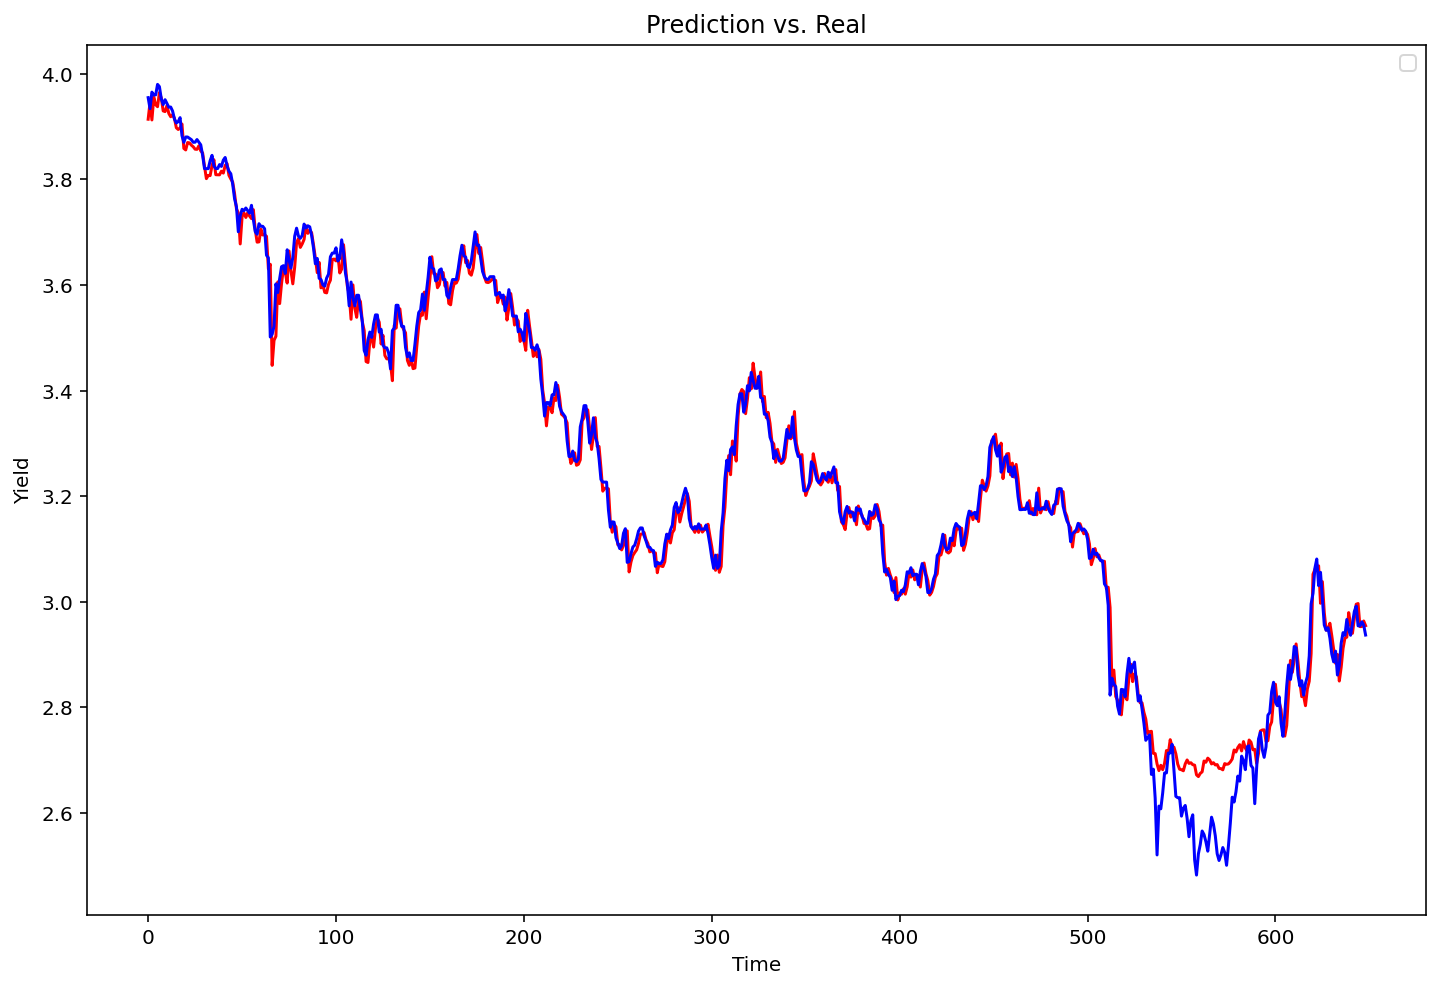

In [212]:
plt.figure(figsize=(12,8))
plt.plot(data_predict, color='red')
plt.plot(test_y, color='blue')
plt.title('Prediction vs. Real')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend();